# SBI validation 

In [1]:
# Copyright (C) 2024 Nicholas Choustikov, Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize

import photonion
import setup
import pandas as pd
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM
cosmology = FlatLambdaCDM(70, 0.3)
custom_colours = [(50/256,14/256,59/256), (76/256, 42/256, 133/256), (107/256, 127/256, 215/256), (188/256, 237/256, 246/256), (221/256, 251/256, 210/256)]

%load_ext autoreload
%autoreload 2
%matplotlib inline

fpath = "/Users/choustikov/Documents/DPhil/science/SPHINX/SPHINX-20-data/data/all_basic_data.csv"
df = pd.read_csv(fpath)
basepath = "../models"
target = "nion"
kind = "JADES"
train_new = False
num_nets = 10
fesc_min = 1e-6

# Build class to read/manipulate SPHINX data
frame = photonion.SPHINXData(fpath)

# Get test/train data split
Xtrain, Xtest, ytrain, ytest, train_galindxs, test_galindxs, __ = frame.make_Xy(
    setup.test_fraction, target_name=target, fesc_min=fesc_min, reweigh_data=True, n_reweigh=5, kind='JADES', muv_norm=True, seed=43)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Train the model

Hyperparameters assumed to have been previously find by `run_hyper_sbi.py` script.

In [ ]:
target_scaling = "logit_standard" if target == "fesc" else "standard"
name = f"SBI_{kind}_{target}"
if train_new:
    train_args, model_args = setup.sbi_read_best_params(basepath, target, kind)
    print(f"Train args: {train_args}")
    print(f"Model args: {model_args}\n")
    reg = photonion.SBIRegressor(target_scaling, num_nets=num_nets,
                                 out_dir=basepath, name=name, model_type='mdn')
    reg.fit(Xtrain, ytrain, verbose=True)
else:
    reg = photonion.SBIRegressor.from_config(basepath, name)

## Model validation

### Goodness-of-fit checks

In [3]:
scores = reg.evaluate(Xtest, ytest, n_samples=1000)
print()
for k, v in scores.items():
    print(f"{k}: {v:.5f}")

Sampling: 100%|██████████| 2610/2610 [00:05<00:00, 504.60it/s]



Mean_AE_loglog: 0.00417
Median_AE_loglog: 0.00301
RMSE_loglog: 0.00588
Mean_AE_latent: 0.43258
Median_AE_latent: 0.31380
RMSE_latent: 0.60712


### Comparison of $q(\theta_{\rm train} | X_{\rm train})$ and $q(\theta_{\rm test} | X_{\rm train})$

In [4]:
lp_train = reg.log_prob(Xtrain, ytrain)
lp_test = reg.log_prob(Xtest, ytest)

Log-probability: 100%|██████████| 2610/2610 [00:27<00:00, 93.92it/s]


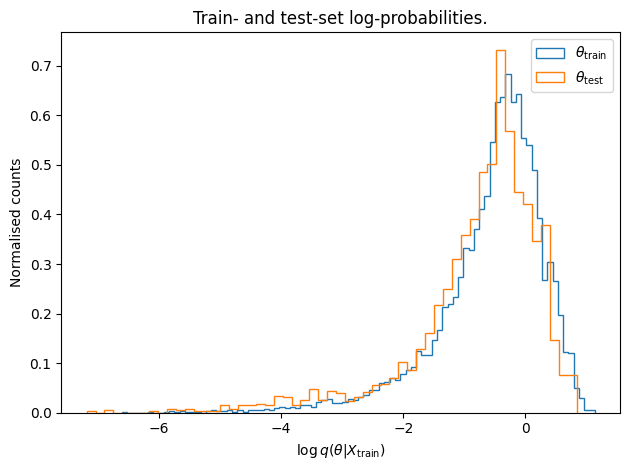

In [8]:
lp_min = -7.5

plt.figure()
plt.title("Train- and test-set log-probabilities.")
plt.hist(lp_train[lp_train > lp_min], bins="auto", histtype="step",
         label=r"$\theta_{\rm train}$", density=True)
plt.hist(lp_test[lp_test > lp_min], bins="auto", histtype="step",
         label=r"$\theta_{\rm test}$", density=True)
plt.legend()
plt.xlabel(r"$\log q(\theta | X_{\rm train})$")
plt.ylabel("Normalised counts")
plt.tight_layout()
plt.savefig(f"../plots/sbi_{target}_logprob.png", dpi=450)

### Validation and train log-probabilities

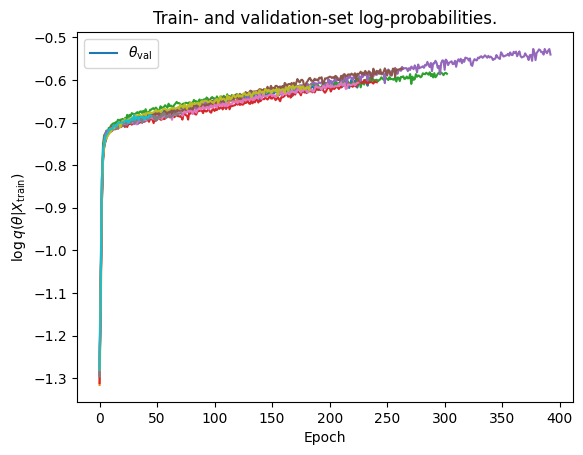

In [10]:
yval = reg.validation_log_probs
ytrain = reg.training_log_probs
plot_train = False

plt.figure()
cols = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
plt.title("Train- and validation-set log-probabilities.")
for i in range(reg.num_nets):
    plt.plot(np.arange(len(yval[i])), yval[i],
             label=r"$\theta_{\rm val}$" if i == 0 else None, c=cols[i])
    if plot_train:
        plt.plot(np.arange(len(ytrain[i])), ytrain[i],
                 label=r"$\theta_{\rm train}$" if i == 0 else None, c=cols[i],
                 ls="dashed")
plt.xlabel("Epoch")
plt.ylabel(r"$\log q(\theta | X_{\rm train})$")
plt.legend()
plt.savefig(f"../plots/sbi_{target}_logprob_evolution.png", dpi=450)

### PIT plots

In [11]:
pit = reg.calculate_pit(Xtest, ytest, n_samples=1000)

Sampling: 100%|██████████| 2610/2610 [00:05<00:00, 513.48it/s]


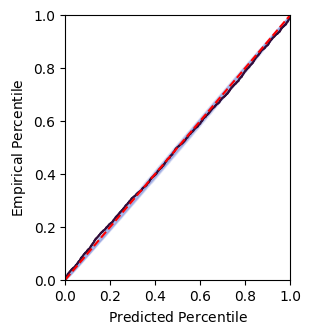

In [15]:
#making the plot
f, axs = plt.subplots(1,1,figsize=(3.31,3.31),sharex=True,sharey=True)
plt.subplots_adjust(left=0.17, right=0.85, top=0.95, bottom=0.15)

unicov = [np.sort(np.random.uniform(0, 1, len(pit))) for j in range(1000)]
unip = np.percentile(unicov, [5, 16, 84, 95], axis=0)

cdf = np.linspace(0, 1, len(pit))

axs.plot(pit, cdf, color=custom_colours[0])
axs.fill_between(cdf, unip[0], unip[-1], color=custom_colours[2], alpha=0.2)
axs.fill_between(cdf, unip[1], unip[-2], color=custom_colours[2], alpha=0.4)

axs.plot(cdf, cdf, c='r', ls='--')
axs.set_xlabel(r'$\rm Predicted\;Percentile$')
axs.set_ylabel(r'$\rm Empirical\;Percentile$')
axs.set_xlim([0,1])
axs.set_ylim([0,1])

plt.savefig('../plots/PIT.png', bbox_inches='tight')

### Latent space distribution of residuals on the test set

In [13]:
ysummary = reg.sample_summarized(Xtest, n_samples=3000, inverse_transform=False)

Summarizing: 100%|██████████| 2610/2610 [00:31<00:00, 82.89it/s]


/var/folders/kt/2sb01mhd4gdfwk888xqz6q600000gq/T/ipykernel_58949/3316152785.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(frameon=False)


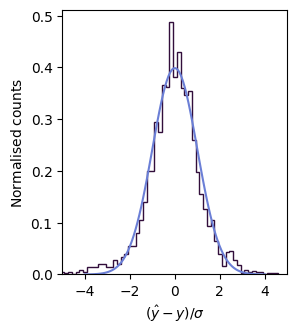

In [14]:
# Standardised residuals plot
f, axs = plt.subplots(1,1,figsize=(3.31,3.31),sharex=True,sharey=True)
plt.subplots_adjust(left=0.17, right=0.85, top=0.95, bottom=0.15)
ymean = ysummary[:, 0]
ystd = (ysummary[:, 2] - ysummary[:, 1]) / 2
z = (ymean - reg.transform_target(ytest)) / ystd

axs.hist(z, bins=75, density=1, histtype='step', color=custom_colours[0])

xrange = np.linspace(-4, 4, 100)
axs.plot(xrange, np.exp(-0.5 * xrange ** 2) / np.sqrt(2 * np.pi), color=custom_colours[2])#, label=r"$\rm Standard\;Gaussian$")

axs.set_xlabel(r"$(\hat{y} - y) / \sigma$")
axs.set_ylabel(r"$\rm Normalised \;counts$")

axs.set_xlim(-5, 5)
axs.legend(frameon=False)

plt.savefig(f"../plots/sbi_{target}_latent_residuals.png", dpi=450)

## Full histogram comparison

In [16]:
# Collecting data from the SPHINX public data release (Katz+23)

ndir = 10
all_fesc = []
all_zs = []
all_halo_id = []
all_f070w = []
all_f090w = []
all_f115w = []
all_f140m = []
all_f150w = []
all_f162m = []
all_f182m = []
all_f200w = []
all_f210m = []
all_f250m = []
all_f277w = []
all_f300m = []
all_f335m = []
all_f356w = []
all_f360m = []
all_f410m = []
all_f430m = []
all_f444w = []
all_f460m = []
all_f480m = []
all_nion = []
all_directions = []

# Iterate over rows/objects in the dataset
for i, row in df.iterrows():
   # Loop over 10 line of sight directions
   for j in range(ndir):
      all_directions.append(j)
      all_fesc.append(row['f_esc'])
      all_zs.append(row['redshift'])
      all_halo_id.append(row[f'halo_id'])
      all_f070w.append(row[f'F070W_dir_{j}'])
      all_f090w.append(row[f'F090W_dir_{j}'])
      all_f115w.append(row[f'F115W_dir_{j}'])
      all_f140m.append(row[f'F140M_dir_{j}'])
      all_f150w.append(row[f'F150W_dir_{j}'])
      all_f162m.append(row[f'F162M_dir_{j}'])
      all_f182m.append(row[f'F182M_dir_{j}'])
      all_f200w.append(row[f'F200W_dir_{j}'])
      all_f210m.append(row[f'F210M_dir_{j}'])
      all_f250m.append(row[f'F250M_dir_{j}'])
      all_f277w.append(row[f'F277W_dir_{j}'])
      all_f300m.append(row[f'F300M_dir_{j}'])
      all_f335m.append(row[f'F335M_dir_{j}'])
      all_f356w.append(row[f'F356W_dir_{j}'])
      all_f360m.append(row[f'F360M_dir_{j}'])
      all_f410m.append(row[f'F410M_dir_{j}'])
      all_f430m.append(row[f'F430M_dir_{j}'])
      all_f444w.append(row[f'F444W_dir_{j}'])
      all_f460m.append(row[f'F460M_dir_{j}'])
      all_f480m.append(row[f'F480M_dir_{j}'])
      all_nion.append(row['f_esc'] + row['ionizing_luminosity'])

# Convert to arrays for future ease
all_directions = np.array(all_directions)
all_fesc = np.array(all_fesc)
all_zs = np.array(all_zs)
all_halo_id = np.array(all_halo_id)
all_f070w = np.array(all_f070w)
all_f090w = np.array(all_f090w)
all_f115w = np.array(all_f115w)
all_f140m = np.array(all_f140m)
all_f150w = np.array(all_f150w)
all_f162m = np.array(all_f162m)
all_f182m = np.array(all_f182m)
all_f200w = np.array(all_f200w)
all_f210m = np.array(all_f210m)
all_f250m = np.array(all_f250m)
all_f277w = np.array(all_f277w)
all_f300m = np.array(all_f300m)
all_f335m = np.array(all_f335m)
all_f356w = np.array(all_f356w)
all_f360m = np.array(all_f360m)
all_f410m = np.array(all_f410m)
all_f430m = np.array(all_f430m)
all_f444w = np.array(all_f444w)
all_f460m = np.array(all_f460m)
all_f480m = np.array(all_f480m)
all_nion = np.array(all_nion)

In [17]:
def get_MABs(f090, f115, f150, f200, f277, f356, z, return_muv=False):
   """
   Fit the UV continuum and return the apparent UV magnitude at 1500A (rest)
   NOTE: While we already know MABs for SPHINX galaxies, we take this approach assuming
         we only had the photometric information

   Parameters
   ----------
   f090 : float
      magnitude in F090W
   f115 : float
      magnitude in F115W
   f150 : float
      magnitude in F150W
   f200 : float
      magnitude in F200W
   f277 : float
      magnitude in F277W
   f356 : float
      magnitude in F356W
   z    : float
      redshift
   return_muv : boolean (optional)
      return the result as an absolute magnitude

   Returns
   -------
   str

   """

   # generic power law
   def func_loc(x,a,b):
      return a*x**b
   
   # filter wavelengths
   #  90, 115, 150, 200, 277, 335, 356, 410, 444
   ws = np.array([0.89824364, 1.14859202, 1.49442228, 1.97811383, 2.76120868, 3.3587610, 3.54834844, 4.07932817, 4.37878307])
   
   # convert MAB to MUV
   def get_muv(ab,z):
      lum_dist = cosmology.luminosity_distance(z).to('pc').value
      M = ab + 5*(1 - np.log10(lum_dist)) +2.5*np.log10(1+z)
      return M
   
   # choosing the closest filters to 1500A (rest)
   MABs = []
   for i in range(len(z)):
      if (z[i] >= 4.5) & (z[i] < 5.25):
         flux = np.array([f090[i], f115[i], f150[i]])
         w = np.array([ws[0], ws[1], ws[2]])
      elif (z[i]>= 5.25) & (z[i] < 7.25):
         flux = np.array([f115[i], f150[i], f200[i]])
         w = np.array([ws[1], ws[2], ws[3]])
      elif (z[i] >= 7.25) & (z[i] < 9.75):
         flux = np.array([f150[i], f200[i], f277[i]])
         w = np.array([ws[2], ws[3], ws[4]])
      elif (z[i] >= 9.75) & (z[i] <= 13):
         flux = np.array([f200[i], f277[i], f356[i]])
         w = np.array([ws[3], ws[4], ws[6]])
      else:
         print(f'{z[i]} outside redshift range, no known model')
         continue
      
      # fit the function
      val, pcov = curve_fit(func_loc, w, (flux))
      
      # find value at 1500A (red-shifted)
      lam = 1500  / 1e4 * (1 + z[i])
      MAB = func_loc(lam, *val)
      if return_muv:
         MABs.append(get_muv((MAB), z[i]))
      else:
         MABs.append((MAB))
   return np.array(MABs)

all_mab = get_MABs(all_f090w, all_f115w, all_f150w, all_f200w, all_f277w, all_f356w, all_zs, return_muv=False)

Summarizing: 100%|██████████| 12970/12970 [00:31<00:00, 416.73it/s]


For ${\rm All\; } z$, MAE = 0.31


Summarizing: 100%|██████████| 3620/3620 [00:08<00:00, 416.06it/s]


For $z = 4.64$, MAE = 0.31


Summarizing: 100%|██████████| 3150/3150 [00:07<00:00, 446.59it/s]


For $z = 5$, MAE = 0.31


Summarizing: 100%|██████████| 2700/2700 [00:06<00:00, 441.70it/s]


For $z = 6$, MAE = 0.3


Summarizing: 100%|██████████| 1720/1720 [00:03<00:00, 437.38it/s]


For $z = 7$, MAE = 0.35


Summarizing: 100%|██████████| 670/670 [00:01<00:00, 436.54it/s]


For $z = 8$, MAE = 0.31


Summarizing: 100%|██████████| 630/630 [00:01<00:00, 459.00it/s]


For $z = 9$, MAE = 0.29


Summarizing: 100%|██████████| 480/480 [00:01<00:00, 423.46it/s]


For $z = 10$, MAE = 0.25


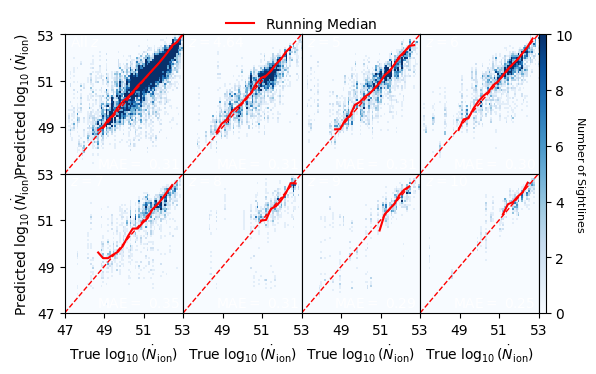

In [39]:
def moving_window(xv,yv,xmin,xmax,window,dx,median=False,min_gal=50,log=False):
   """
   """
   if log:
      yv = 10.**yv
      x1 = xmin
      x2 = xmin + window

      xx = []; yy = []; ss = []
      while x2 < xmax:
         filt = (xv >= x1) & (xv < x2)
         if filt.sum() > min_gal:
            xx.append(0.5 * (x1 + x2))
            if median:
                  yy.append(np.median(yv[filt]))
            else:
                  yy.append(yv[filt].mean())
            ss.append(yv[filt].std())

         x1 += dx
         x2 = x1 + window

      return xx,np.log10(yy),np.log10(ss)
   else:
      x1 = xmin
      x2 = xmin + window

      xx = []; yy = []; ss = []
      while x2 < xmax:
         filt = (xv >= x1) & (xv < x2)
         if filt.sum() > min_gal:
            xx.append(0.5 * (x1 + x2))
            if median:
                  yy.append(np.median(yv[filt]))
            else:
                  yy.append(yv[filt].mean())
            ss.append(yv[filt].std())

         x1 += dx
         x2 = x1 + window

      return xx,yy,ss
      


f, axs = plt.subplots(2,4,figsize=(6.97,6.97 * 2/4))
plt.subplots_adjust(left=0.17, right=0.85, top=0.95, bottom=0.15)
axs = axs.ravel()
redshifts = ['all', 4.64, 5, 6, 7, 8, 9, 10]
red_labs = [r'${\rm All\; } z$', r'$z = 4.64$', r'$z = 5$', r'$z = 6$', r'$z = 7$', r'$z = 8$', r'$z = 9$', r'$z = 10$']
plt.subplots_adjust(wspace=0., hspace=0.)
cmap = 'Blues'

verbose = False
only_training = False
aayush = False
log = True
median=True

#Get data
X = [all_f115w, all_f150w, all_f200w, all_f277w, all_f335m, all_f356w, all_f410m, all_f444w, all_f115w-all_f150w, all_f150w-all_f277w, all_f277w-all_f444w, all_mab, all_zs]
X = [all_f115w - all_mab, all_f150w - all_mab, all_f200w - all_mab, all_f277w - all_mab, all_f335m - all_mab, all_f356w - all_mab, all_f410m - all_mab, all_f444w - all_mab, all_f115w-all_f150w, all_f150w-all_f277w, all_f277w-all_f444w,all_mab, all_zs]
y = all_nion

#just the training set
if only_training:
    X = Xtest
    red_test = Xtest[:,-1]
    y = ytest

for i,ax in enumerate(axs):   
   #Build the redshift filter
   
   if only_training:
      z_filt = (red_test == redshifts[i]) & (~np.isnan(y))
      if redshifts[i] == 'all':
         z_filt = (~np.isnan(y))
   else:
      z_filt = (all_zs == redshifts[i]) & (~np.isnan(y)) 
      if redshifts[i] == 'all':
         z_filt = (all_zs >= -1) & (~np.isnan(y)) 

      z_filt &= all_fesc > np.log10(fesc_min)
   
   #Apply the redshift filter
   Xval = [x[z_filt] for x in X]#.T    
   y_true = y[z_filt]

   #Sample from the posterior
   Xs = np.array(Xval).T
   ys = reg.sample_summarized(Xs, n_samples=100)
   ys = ys.T[0]

   #plotting the data
   bins = np.linspace(47, 53.5, 76)
   thing = ax.hist2d(y_true, ys,  bins=bins, cmap=cmap, rasterized=True, vmin=0, vmax=10)
   
   #plot the 1:1 line
   xs = np.linspace(47, 53.5, 100)
   ax.plot(xs, xs, c='r', lw=1, ls='--')

   #Calculate median average error
   MAE = np.median(np.abs(ys - y_true))

   #plot the running mean
   xx,yy,ss = moving_window(ys,y_true, 48.5,53.2,0.4,0.25, median=median, min_gal=40,log=log)
   if median:
      ax.plot((xx), (yy), lw=1.5, c='r', label=r'$\rm Running\; Median$')
   else:
      ax.plot((xx), (yy), lw=1.5, c='r', label=r'$\rm Running\; Mean$')

   #print the redshift and MAE information
   stri = f'{MAE:.2f}'
   ax.text(48.65, 47.25, s=r'${\rm MAE} = $' + rf'$\; {{{stri}}}$', color='w')
   ax.text(47.25, 52.5, s=red_labs[i], color='w')
   print(f'For {red_labs[i]}, MAE = {np.round(MAE, 2)}')

   if aayush:
      ax.set_xlim(47, 53.5)
      ax.set_ylim(47, 53.5)
   else:
      ax.set_xlim(47, 53)
      ax.set_ylim(47, 53)

      #make labels and ticks look nice
      if i % 4 != 0:
         ax.set_yticks([])
      elif i ==0:
         ax.set_yticks([49, 51, 53]) 
         ax.set_ylabel(r'${\rm Predicted\; } \log_{10}(\dot{N}_{\rm ion})$')
      elif i ==4:
         ax.set_yticks([47, 49, 51, 53])
         ax.set_ylabel(r'${\rm Predicted\; } \log_{10}(\dot{N}_{\rm ion})$')
      if i < 4:
         ax.set_xticks([])
      elif i == 4:
         ax.set_xticks([47, 49, 51, 53])
         ax.set_xlabel(r'${\rm True\;} \log_{10}(\dot{N}_{\rm ion})$')
      else:
         ax.set_xticks([49, 51, 53])
         ax.set_xlabel(r'${\rm True\;} \log_{10}(\dot{N}_{\rm ion})$')

      #add a legend
      if i == 1:
         ax.legend(frameon=False, bbox_to_anchor=(1, 1.075), loc='center', ncols=2)

#Colorbar trickery
cax = f.add_axes([0.85, 0.15, 0.01, 0.8])
cbar =  mpl.colorbar.ColorbarBase(cax, norm=Normalize(0,10), spacing='proportional', cmap=cmap)
cbar.ax.set_ylabel(r'$\rm Number\; of\; Sightlines$', rotation=270, fontsize=8, labelpad=10)

#save figure
plt.savefig('../plots/nion_model_sphinx.png', bbox_inches='tight')


## SBI-ET comparison

In [23]:
from scipy.stats import spearmanr

In [30]:
Xtrain, Xtest, ytrain, ytest, train_galindxs, test_galindxs, __ = frame.make_Xy(
    setup.test_fraction, target_name=target, fesc_min=fesc_min, reweigh_data=True, n_reweigh=5, kind='JADES', muv_norm=True)

In [31]:
reg_sklearn = setup.load_best_model("local_nick", "ET", target, kind)
reg_sklearn.fit(Xtrain, ytrain)

Pipeline(steps=[('feature_scaler', StandardScaler()),
                ('estimator',
                 ExtraTreesRegressor(bootstrap=True,
                                     ccp_alpha=2.65222118058198e-13,
                                     max_depth=33,
                                     max_features=0.919340009649832,
                                     max_samples=0.27022079002840055,
                                     min_impurity_decrease=1.7061831742407581e-15,
                                     min_samples_split=14, n_estimators=481,
                                     n_jobs=1))])

In [34]:
ypred_sklearn = reg_sklearn.predict(Xtest)
ypred_sbi = reg.sample_summarized(Xtest, n_samples=3000, inverse_transform=True)

Summarizing: 100%|██████████| 2610/2610 [00:31<00:00, 83.22it/s]


In [35]:
print(f"Spearman corr. of ET and SBI predictions = {spearmanr(ypred_sbi[:, 0], ypred_sklearn)[0]}")
print(f"MAE of ET predictions                    = {np.median(np.abs(ypred_sklearn - ytest))}")
print(f"MAE of SBI predictions                   = {np.median(np.abs(ypred_sbi[:, 0] - ytest))}")
print(f"MAE of SBI - ET predictions              = {np.median(np.abs(ypred_sbi[:, 0] - ypred_sklearn))}")

Spearman corr. of ET and SBI predictions = 0.9761792502051647
MAE of ET predictions                    = 0.355897483365208
MAE of SBI predictions                   = 0.350058926028602
MAE of SBI - ET predictions              = 0.12646068746155592


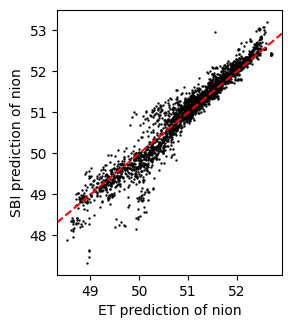

In [38]:
plot_uncertainty = False

f, axs = plt.subplots(1,1,figsize=(3.31,3.31),sharex=True,sharey=True)
plt.subplots_adjust(left=0.17, right=0.85, top=0.95, bottom=0.15)

if plot_uncertainty:
    dyupper = ypred_sbi[:, 1] - ypred_sbi[:, 0]
    dylower = ypred_sbi[:, 0] - ypred_sbi[:, 2]
    axs.errorbar(ypred_sklearn, ypred_sbi[:, 0], yerr=[dylower, dyupper], fmt="o", ms=1, capsize=3)
else:
    axs.scatter(ypred_sklearn, ypred_sbi[:, 0], s=0.5, c='k')

x0 = np.median(ytest)
axs.axline([x0, x0], slope=1, color="r", ls="--")
axs.set_xlabel(f"ET prediction of {target}")
axs.set_ylabel(f"SBI prediction of {target}")

plt.savefig(f"../plots/sbi_et_{target}_comparison.png", dpi=450)
